Importing all required libraries and functions first

In [1]:

!pip install bm3d
import os
import time
import bm3d
import matplotlib
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.metrics import structural_similarity

Defaulting to user installation because normal site-packages is not writeable


Defining functions for Artificial Noise-Adding Techniques
Gaussian Noise, as defined below

In [2]:
def add_noise(image, sigma=10): #Gaussian noise
    image = image + np.random.normal(0, (sigma*100), image.shape)
    return (image)
    # return (add_blur(image, 3))

Defining functions for alternate Artificial Noise Technique
Salt 'n Pepper, as below 

In [3]:
# def add_noise(image, sigma=0.1): #Salt-and-Pepper noise
#     noisy = image.copy()
#     noisy[np.random.rand(*image.shape) < sigma] = 0
#     noisy[np.random.rand(*image.shape) < sigma] = 255
#     return noisy
#     # return (add_blur(noisy, 3))

Defining functions for Testing Methodology - PSNR and SSIM

In [4]:
def PSNR (original, processed):
    error = np.mean((original - processed)**2)
    if error == 0:
        return 100
    PIXEL_MAX = 255.0
    return (20*np.log10(PIXEL_MAX/np.sqrt(error)))

def SSIM (original, processed):
    return (structural_similarity (original, processed, multichannel=True))

Defining functions for Median Filter and conversion of images to grayscale

In [5]:
def grayscale(img):
	return np.dot(img[...,:3], [0.299, 0.587, 0.114])

def add_blur(image, kernel_size): 
    kernel = np.ones((kernel_size, kernel_size))/(kernel_size**2)
    blurred = convolve2d(image, kernel, mode='same')
    return (blurred)

def median_filter(data, window):
    temp = []
    indexer = window // 2
    data_final = []
    data_final = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):
        for j in range(len(data[0])):
            for k in range(window):
                if i + k - indexer < 0 or i + k - indexer > len(data) - 1:
                    for c in range(window):
                        temp.append(0)
                else:
                    if j + k - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for x in range(window):
                            temp.append(data[i + k - indexer][j +  x - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final

Creating arrays for Image Names/Locations, SSIM, PSNR lists and other processed values

In [6]:
images = ["dataset/pixel.jpg", "dataset/1to1.jpg", "dataset/fashion.jpg", "dataset/wildlife.jpg", "dataset/nature.jpg", "dataset/fractal.jpg", "dataset/painting.jpg", "dataset/food.jpg", "dataset/cells.jpg", "dataset/aurora.jpg", "dataset/beach.jpg", "dataset/snowflake.jpg"]
image_list = []
noisy_image_list = []
denoised_image_bm3d = []
denoised_image_median = []
denoised_image_mixed = []

psnr_noisy_list = []
ssim_noisy_list = []

bm3d_times = []
bm3d_ssim = []
bm3d_psnr = []

median_times = []
median_ssim = []
median_psnr = []

mixed_times = []
mixed_ssim = []
mixed_psnr = []

Importing images, converting to grayscale and saving to arrays

In [7]:
for image in images:
    image = os.path.join(image) 
    image_list.append(grayscale(plt.imread(image)))

for image in image_list:
    noisy_image_list.append(add_noise(image, .05))

Processing images with Median Filter, BM3D and saving to arrays. 
Images are also being stored locally.

In [8]:
count = 1

for image in noisy_image_list:
    # Processing Median Filter
    start = time.time()
    denoised = median_filter(image, 3)
    end = time.time()
    denoised_image_median.append(denoised)
    img = os.path.join("processed_median/")
    img += str(count)
    img+= ".jpg"
    matplotlib.image.imsave(img, denoised, cmap='gray')
    median_times.append(end - start)

    denoised = 0
    
    # Processing BM3D
    start = time.time()
    denoised = bm3d.bm3d(image, sigma_psd=.3, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    end = time.time()
    denoised_image_bm3d.append(denoised)
    img = os.path.join("processed_bm3d/")
    img += str(count)
    img+= ".jpg"
    matplotlib.image.imsave(img, denoised, cmap='gray')
    bm3d_times.append(end - start)

    denoised = 0

    # Processing Mixed
    start = time.time()
    denoised = median_filter(image, 3)
    denoised = add_blur(denoised, 2)
    end = time.time()
    denoised_image_mixed.append(denoised)
    img = os.path.join("processed_mixed/")
    img += str(count)
    img+= ".jpg"
    matplotlib.image.imsave(img, denoised, cmap='gray')
    mixed_times.append(end - start)

    count += 1    

In [9]:
# for i in range(len(images)):
#     print(image_list[i].shape)
#     print(noisy_image_list[i].shape)
#     print(denoised_image_bm3d[i].shape)
#     print(denoised_image_median[i].shape)
#     print(denoised_image_mixed[i].shape)
    

Processing PSNR, SSIM tests and saving values to arrays

In [10]:
for i in range(len(images)):
    psnr_noisy_list.append(PSNR(image_list[i], noisy_image_list[i]))
    ssim_noisy_list.append(SSIM(image_list[i], noisy_image_list[i]))
    bm3d_ssim.append(SSIM(image_list[i], denoised_image_bm3d[i]))
    bm3d_psnr.append(PSNR(image_list[i], denoised_image_bm3d[i]))
    median_ssim.append(SSIM(image_list[i], denoised_image_median[i]))
    median_psnr.append(PSNR(image_list[i], denoised_image_median[i]))
    mixed_ssim.append(SSIM(image_list[i], denoised_image_mixed[i]))
    mixed_psnr.append(PSNR(image_list[i], denoised_image_mixed[i]))

In [11]:
for i in range(len(images)):
    images[i] = images[i].replace("dataset/", "")
    images[i] = images[i].replace(".jpg", "")

for i in range (len(images)):
    print(images[i], i )

pixel 0
1to1 1
fashion 2
wildlife 3
nature 4
fractal 5
painting 6
food 7
cells 8
aurora 9
beach 10
snowflake 11


Plotting PSNR Graphs for the two filters and in noisy state

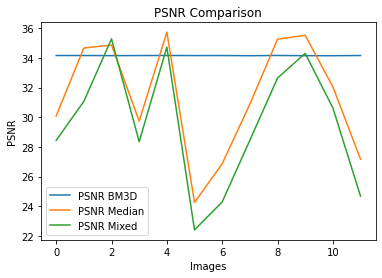

In [12]:
plt.plot(bm3d_psnr, label="PSNR BM3D")
plt.plot(median_psnr, label="PSNR Median")
plt.plot(mixed_psnr, label="PSNR Mixed")

plt.xlabel("Images")
plt.ylabel("PSNR")

plt.title("PSNR Comparison")
plt.legend()
plt.show()

Plotting SSIM Graphs for the two filters and in noisy state

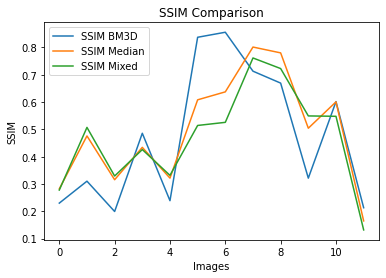

In [13]:
plt.plot(bm3d_ssim, label="SSIM BM3D")
plt.plot(median_ssim, label="SSIM Median")
plt.plot(mixed_ssim, label="SSIM Mixed")

plt.xlabel("Images")
plt.ylabel("SSIM")

plt.title("SSIM Comparison")
plt.legend()
plt.show()

Plotting Time Graphs for the two filters and in noisy state

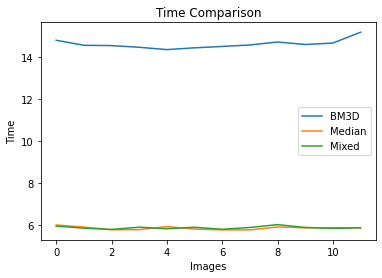

In [14]:
plt.plot(bm3d_times, label="BM3D")
plt.plot(median_times, label="Median")
plt.plot(mixed_times, label="Mixed")

plt.xlabel("Images")
plt.ylabel("Time")

plt.title("Time Comparison")
plt.legend()
plt.show()

% improvement of Median over BM3D

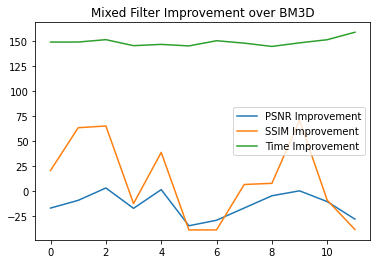

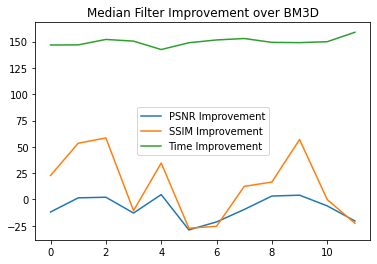

In [15]:
blur_imp_psnr = []
blur_imp_ssim = []
blur_imp_time = []
med_imp_psnr = []
med_imp_ssim = []
med_imp_time = []

for i in range(len(images)):
    # print(bm3d_psnr[i], "   ", mixed_psnr[i])
    blur_imp_psnr.append((mixed_psnr[i] - bm3d_psnr[i])/bm3d_psnr[i]*100) 
    blur_imp_ssim.append((mixed_ssim[i] - bm3d_ssim[i])/bm3d_ssim[i]*100)
    blur_imp_time.append((bm3d_times[i] - mixed_times[i])/mixed_times[i]*100)

    med_imp_psnr.append((median_psnr[i] - bm3d_psnr[i])/bm3d_psnr[i]*100)
    med_imp_ssim.append((median_ssim[i] - bm3d_ssim[i])/bm3d_ssim[i]*100)
    med_imp_time.append((bm3d_times[i] - median_times[i])/median_times[i]*100)
    

# print(improvement_psnr)
# print(improvement_ssim)
# print(improvement_time)

# print (blur_imp_psnr)

plt.plot(blur_imp_psnr, label = "PSNR Improvement")
plt.plot(blur_imp_ssim,  label = "SSIM Improvement")
plt.plot(blur_imp_time, label = "Time Improvement")
plt.title("Mixed Filter Improvement over BM3D")
plt.legend()
plt.show()

plt.plot(med_imp_psnr, label = "PSNR Improvement")
plt.plot(med_imp_ssim, label = "SSIM Improvement")
plt.plot(med_imp_time, label = "Time Improvement")
plt.title("Median Filter Improvement over BM3D") 
plt.legend()
plt.show()

Differences in Median and Mixed Algorithm

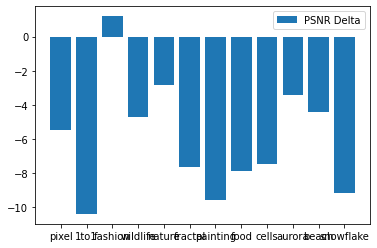

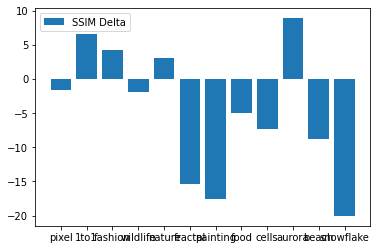

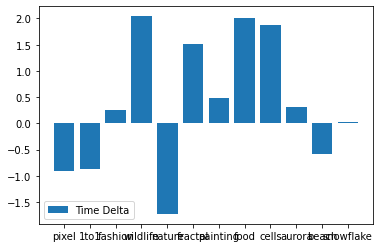

In [16]:
psnr_delta= []
ssim_delta = []
time_delta = []

for i in range(len(images)):
    psnr_delta.append((mixed_psnr[i] - median_psnr[i])/median_psnr[i]*100)
    ssim_delta.append((mixed_ssim[i] - median_ssim[i])/median_ssim[i]*100)
    time_delta.append((mixed_times[i] - median_times[i])/median_times[i]*100)

# i = [1,2,3,4,5,6,7,8,9,10,11,12,13]

plt.bar(images, psnr_delta, label = "PSNR Delta")
plt.legend()
plt.show()
plt.bar(images, ssim_delta, label = "SSIM Delta")
plt.legend()
plt.show()
plt.bar(images, time_delta, label = "Time Delta")
plt.legend()
plt.show()